In [1]:
from mindquantum.simulator import Simulator
from mindquantum.core import Circuit
from mindquantum.core import Hamiltonian, UN
from mindquantum.core import H, ZZ, RX, RZ, RY
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.core import QubitOperator
import networkx as nx
import mindspore.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import *
import mindspore as ms
import time
from IPython.display import clear_output


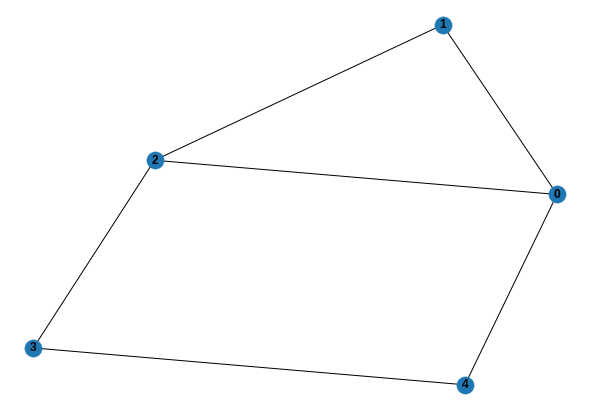

In [32]:
g = nx.Graph()
nx.add_path(g, [0,1])
nx.add_path(g, [1,2])
nx.add_path(g, [2,3])
nx.add_path(g, [3,4])
nx.add_path(g, [0,4])
nx.add_path(g, [0,2])
nx.draw(g,with_labels=True, font_weight='bold')

In [3]:

def noise_layer(g, p_noise, std):
    hc = Circuit()
    for i in g.nodes:
        if np.random.rand() < p_noise:
            hc += RZ(np.random.normal(0,std)).on(i)
    return hc       
def build_hc(g,para):
    hc = Circuit()
    for i in g.edges:
        hc += ZZ(para).on(i)

    return hc
def build_hb(g, para):
    hc = Circuit()
    for i in g.nodes:
        hc += RX(para).on(i)
    return hc
def build_ansatz(g, p, p_noise, std):
    c = Circuit()
    for i in range(p):
        c += build_hc(g,f'g{i}')
        c += noise_layer(g, p_noise, std)
        c += build_hb(g,f'b{i}')
        c += noise_layer(g, p_noise, std)
    return c
def build_ham(g):
    hc = QubitOperator()
    for i in g.edges:
        hc += QubitOperator(f'Z{i[0]} Z{i[1]}')
    return hc

def build_ansatz_par(g, p, pr, p_noise, std):
    c = Circuit()
    for i in range(p):
        c += build_hc(g,pr[2*i])
        c += noise_layer(g, p_noise, std)
        c += build_hb(g,pr[2*i+1])
        c += noise_layer(g, p_noise, std)
    return c


## Layerwise Training

In [ ]:

ms.context.set_context(mode = ms.context.PYNATIVE_MODE, device_target = "CPU")

max_depth = 15 # maximum depth
i_noise = 1 # initial probability of noise 
std = 0.3 # standard deviation for the noise angles

reps_op = 5 # number of repetitions of the optimizer, from which to take the best result  

ham = Hamiltonian(build_ham(g))
init_state_circ = UN(H, g.nodes)
ps = [] # parameters saved, once trained they dont change
data_cut = [] #stores the cut values at diferent depths

for p in range(1,max_depth + 1):
    p_noise = np.exp(-(p-1)/2) # functions to reduce the probability of noise as depth increases
    
    def expectation (pt): # expectation value, takes as input 2 parameters corresponding to the last layer
        circuit= init_state_circ + noise_layer(g, p_noise, std) + build_ansatz_par(g, p-1, ps, p_noise, std)\
            + build_ansatz_par(g, 1, pt, p_noise, std) #QAOA circuit with noisy layers, only the last one is trained
        sim = Simulator('projectq', circuit.n_qubits)
        sim.apply_circuit(circuit)
        e = np.real(sim.get_expectation(ham))# we minimize the expectation value
        sim.flush()
        return e

    best = 0 #this value is updated with the optimization that gives the best performance
    for _ in range(reps_op):
        pt = np.random.rand(2)*2*np.pi
        res = minimize(expectation, pt, method = 'cobyla', \
                                   jac = None) #gradientless optimizer works better with noise
        if res.fun < best: #saves the best run of the optimizer
            best = res.fun
            op_pars = res.x
            
    ps = ps + list(op_pars) #adds the newly trained parameters to the list of previouly trained ones
    data_cut.append((len(g.edges)-best)/2)
    print('depth: ', p,'cut: ',(len(g.edges)-best)/2)

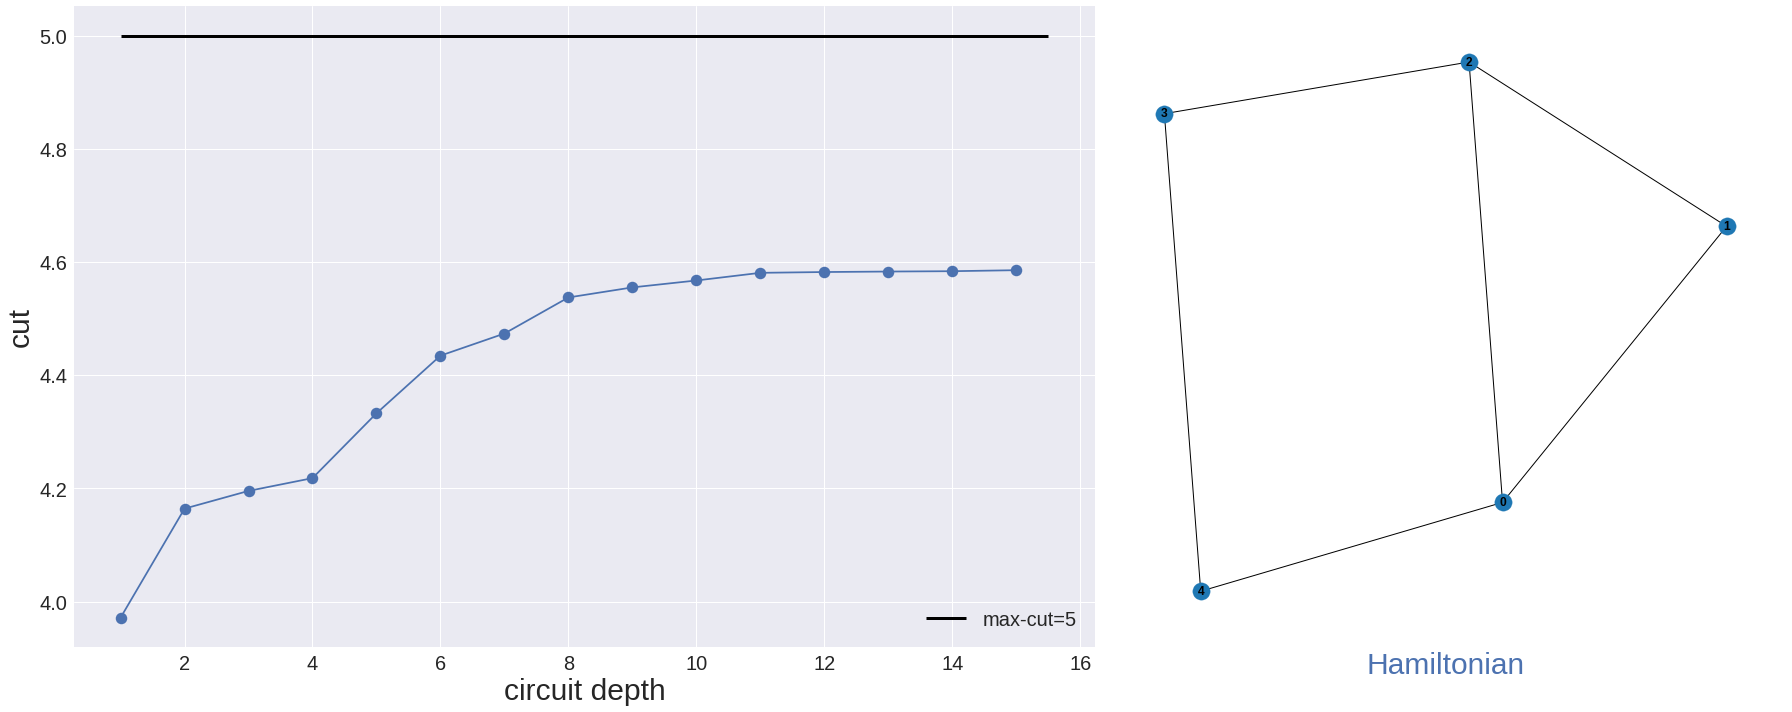

In [18]:

f , (ax1,ax2) = plt.subplots(1,2,figsize = (25,10), gridspec_kw={'width_ratios': [1.5, 1]})
mpl.style.use('seaborn')

P=np.arange(1,max_depth+1)
ax1.plot(P,data_cut,'.-', c = 'C0', markersize=23)
ax1.grid(alpha = 1)

ax1.set_xlabel('circuit depth', fontsize = 30 )
ax1.set_ylabel('cut', fontsize = 30 )
ax1.hlines(5, 1, P[-1] + 0.5, linestyles='solid', linewidth = 3, colors = 'black',\
           label = f'max-cut=5')
ax1.legend(fontsize = 20, loc='lower right')


ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

nx.draw(g,with_labels=True, font_weight='bold')
ax2.set_facecolor("#00000F")
ax2.set_title('Hamiltonian', fontsize = 30, color='C0', y= -0.05 )
# ax1.set_title('', fontsize = 30)

f.subplots_adjust(wspace = 0)
plt.tight_layout()

## Layerwise training for a range of standard deviation values

In [18]:
ms.context.set_context(mode = ms.context.PYNATIVE_MODE, device_target = "CPU")

max_depth = 15 # maximum depth
i_noise = 1 # initial probability of noise 
std_range = np.linspace(0,1,40) # range of standard deviations
reps = 50 # seeds
reps_op = 5 # optimizer repetitions

ham = Hamiltonian(build_ham(g))
init_state_circ = UN(H, g.nodes)
data_std = [] # stores cut values for different standard deviations

for std in std_range:
    data_reps =[] # stores cut values at multiple repetitions for the same standard deviation 
    
    for r in range(reps):
        ps = [] # parameters saved
        
        for p in range(1,max_depth + 1):
            print('std:',std , 'repetition:', r, 'depth:', p)
            p_noise = np.exp(-p/2) # functions to reduce the probability of noise as depth increases
            
            def expectation (pt): # expectation value, takes as input 2 parameters corresponding to the last layer
                circuit = init_state_circ + noise_layer(g, p_noise, std) + build_ansatz_par(g, p-1, ps, p_noise, std)\
                    + build_ansatz_par(g, 1, pt, p_noise, std) # QAOA circuit with noisy layers, only the last one is trained
                sim = Simulator('projectq', circuit.n_qubits)
                sim.apply_circuit(circuit)
                e=np.real(sim.get_expectation(ham)) # we minimize the expectation value
                sim.flush()
                return e

            best=0
            for _ in range(reps_op):
                pt = np.random.rand(2)*2*np.pi
                res = minimize(expectation,pt,method='cobyla', \
                        jac = None) # gradientless optimizer works better with noise
                
                if res.fun < best: # saves the best run of the optimizer
                    best = res.fun
                    best = res.fun
                    op_pars = res.x
                    
            ps = ps + list(op_pars) # adds the newly trained parameters to the list of previouly trained ones
            clear_output()
            
        data_reps.append((len(g.edges)-best)/2)
        
    data_std.append([std,data_reps])

## Plotting

In [30]:
ol_d=data_std
steps=len(std_range)
m=10 #number of cuts in the top m
avg=[]
maxs_av=[] #average of the top m cuts        
maxs_topm=[] #top m maximum overlap
maxs_b=[] #best cuts overall
maxs_w=[] #worst of the top m cuts
maxs_std=[]#standard deviation of the top m
p_ph=[] #probability of phases

for ind in range(steps):
    avg.append(np.mean(ol_d[ind][1]))
    maxs=np.partition(ol_d[ind][1],-m)[-m:]
    maxs_topm.append(maxs) 
    maxs_av.append(np.mean(maxs))
    maxs_b.append(np.max(ol_d[ind][1]))
    maxs_w.append(np.min(maxs))
    maxs_std.append(np.std(maxs))
    p_ph.append(ol_d[ind][0])

#Polynomial fittings    
b_pf=np.polynomial.polynomial.Polynomial.fit(p_ph, maxs_b, 3, domain=None, rcond=None, full=False, w=None, window=None)
w_pf=np.polynomial.polynomial.Polynomial.fit(p_ph, maxs_w, 4, domain=None, rcond=None, full=False, w=None, window=None)
av_pf=np.polynomial.polynomial.Polynomial.fit(p_ph, maxs_av, 3, domain=None, rcond=None, full=False, w=None, window=None)

#noisless line
noiseless=np.ones(steps)*maxs_av[0]

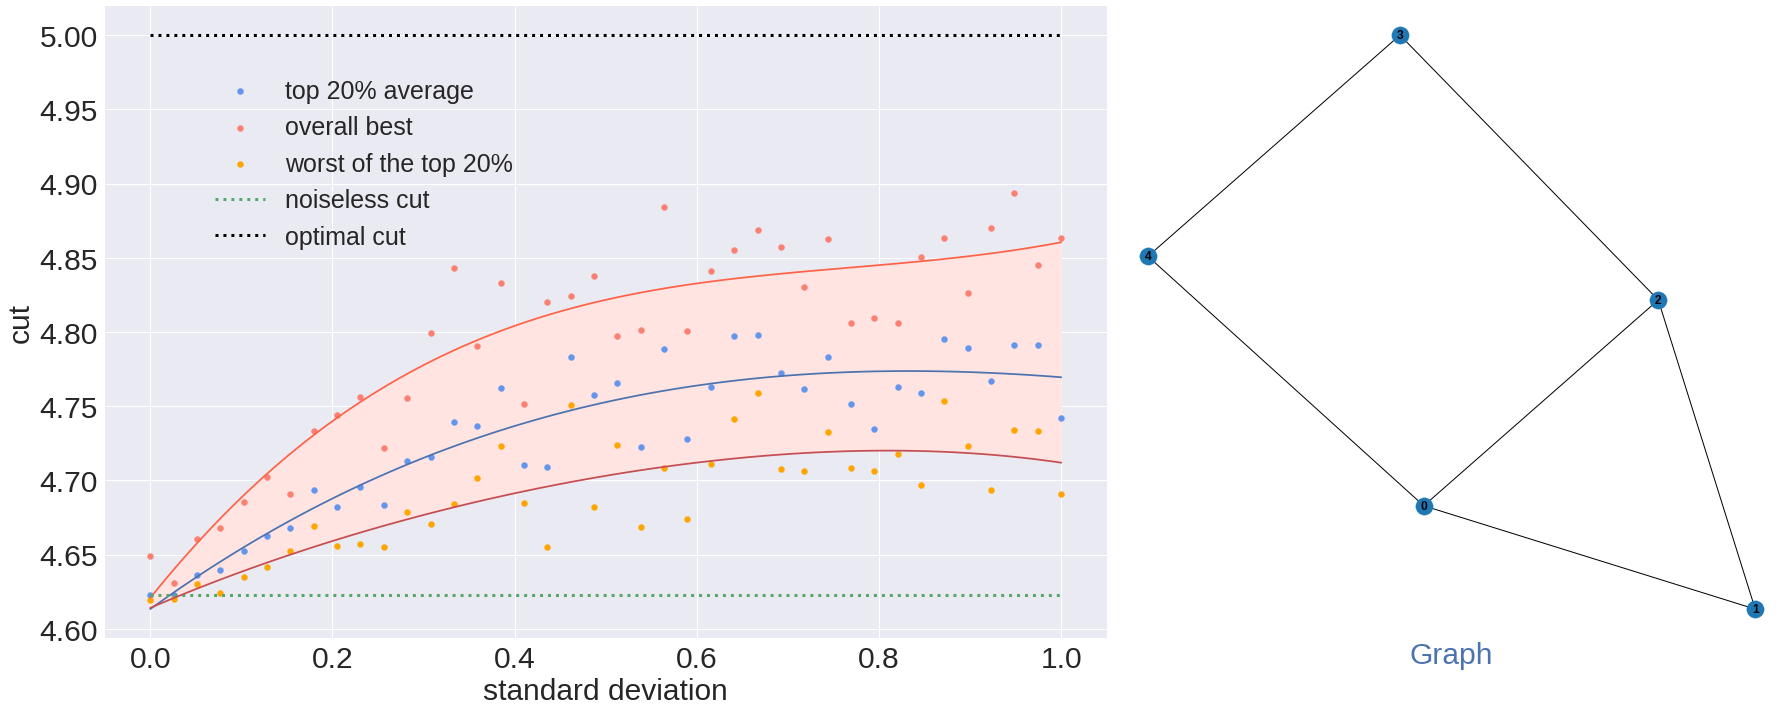

In [31]:

f , (ax1,ax2) = plt.subplots(1,2,figsize = (25,10), gridspec_kw={'width_ratios': [1.5, 1]})
mpl.style.use('seaborn')



ax1.set_ylabel('cut',fontsize = 30)
ax1.set_xlabel('standard deviation',fontsize = 30)
ax1.fill_between(w_pf.linspace()[0],w_pf.linspace()[1], b_pf.linspace()[1], color='mistyrose')
ax1.scatter(p_ph,maxs_av,s=37, label='top 20% average',color='cornflowerblue')
ax1.scatter(p_ph,maxs_b,s=37, label='overall best',color='salmon')
ax1.scatter(p_ph,maxs_w,s=37, label= 'worst of the top 20%',color='orange')

ax1.plot(*av_pf.linspace())
ax1.plot(*b_pf.linspace(),color='tomato')

ax1.plot(p_ph, noiseless, ls=':', label='noiseless cut',linewidth=3)
ax1.plot(*w_pf.linspace())


ax1.hlines(5, 0,1, linestyles=':', linewidth = 3, colors = 'black',\
           label = f'optimal cut')
ax1.legend(fontsize = 25, loc=[0.1,0.6])


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

nx.draw(g,with_labels=True, font_weight='bold')
ax2.set_facecolor("#00000F")
ax2.set_title('Graph', fontsize = 30, color='C0', y= -0.05 )
# ax1.set_title('', fontsize = 30)

f.subplots_adjust(wspace = 0)
plt.tight_layout()
plt.savefig('Max_cut_range_std_with_means_v1.pdf')